In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)
valid_datagen = ImageDataGenerator(
        rescale=1./255,
)

In [4]:
batch_size = 128

data_dir = './images/'

train_data = train_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    target_size=(224, 224),
    shuffle=True,
)
valid_data = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
)

Found 160286 images belonging to 145 classes.
Found 160286 images belonging to 145 classes.


In [5]:
def visualize_images(images,labels):
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    classes = list(train_data.class_indices.keys())
    img_no = 0
    for i in range(3):
        for j in range(3):
            img = images[img_no]
            lbl = np.argmax(labels[img_no])

            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[lbl])
            ax[i,j].set_axis_off()
            img_no+=1

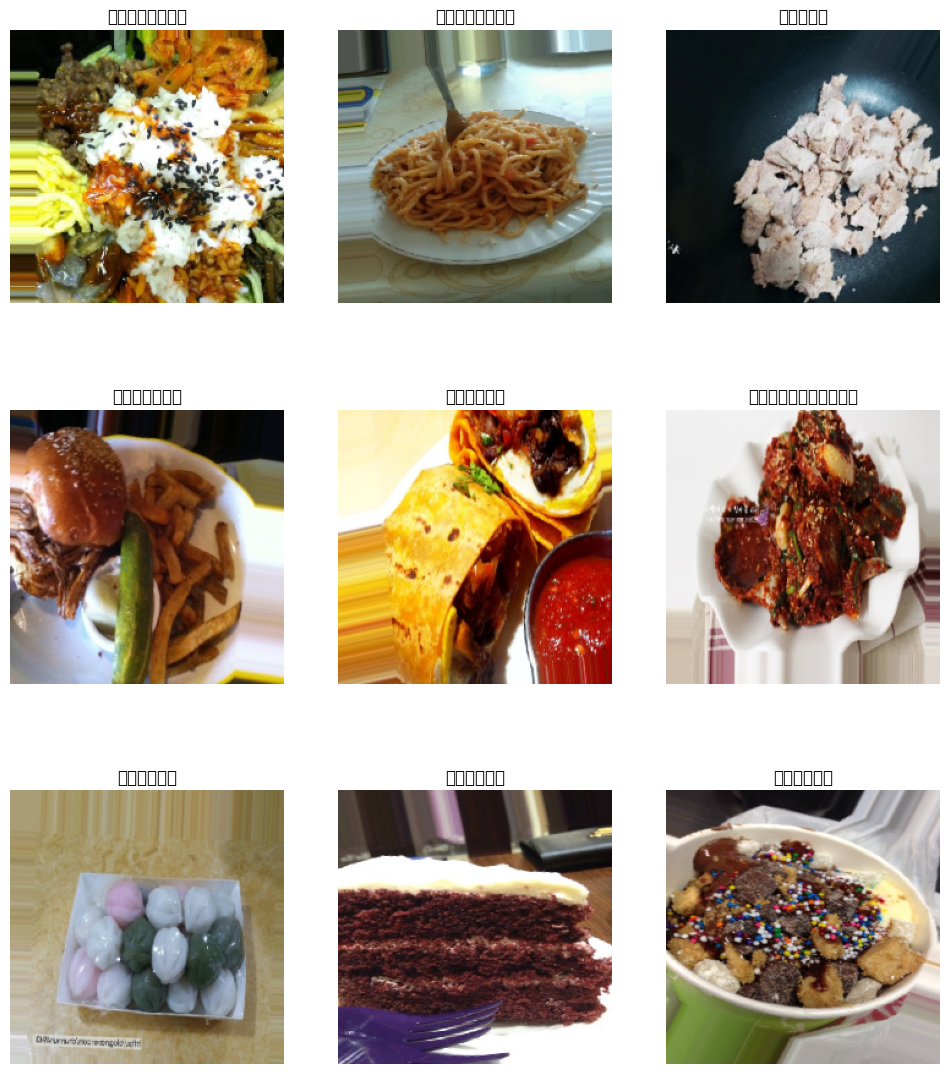

In [6]:
images, labels = next(train_data)
visualize_images(images,labels)

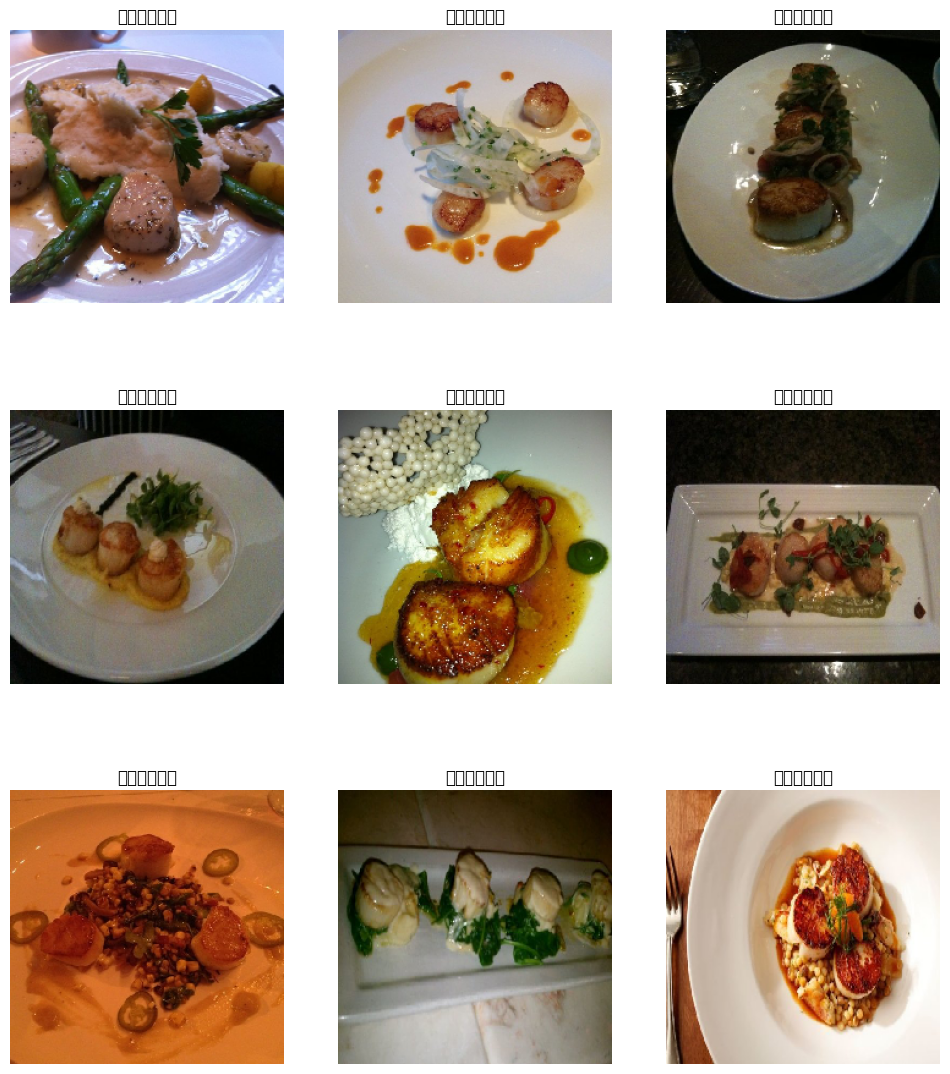

In [7]:
images, labels = next(valid_data)
visualize_images(images,labels)

In [8]:
base = MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
base.trainable = True
model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(145, activation='softmax'))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

In [9]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
log = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log,write_graph=False,update_freq=100)
chkp = ModelCheckpoint('mobilenetv2_tuned.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

In [10]:
!rm -r logs
%reload_ext tensorboard
%tensorboard --logdir logs

In [11]:
history = model.fit(train_data,
                    epochs=20,
                    validation_data = valid_data,
                    callbacks=[early_stop, reduce_lr, tensorboard, chkp])

  21/1253 [..............................] - ETA: 21:43 - loss: 5.5487 - accuracy: 0.0160

In [ ]:
preds = model.predict(valid_data)

1253/1253 [==============================] - 443s 353ms/step


In [ ]:
model_name = 'MobileNet_food_classification.h5'
model.save(model_name, save_format='h5')

In [ ]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)
print(class_map)

{'가리비': 0, '가지볶음': 1, '간장게장': 2, '갈비구이': 3, '갈비찜': 4, '갈비탕': 5, '갈치구이': 6, '갈치조림': 7, '감자전': 8, '감자조림': 9, '감자탕': 10, '감자튀김': 11, '갓김치': 12, '건새우볶음': 13, '경단': 14, '계란국': 15, '계란말이': 16, '계란찜': 17, '계란후라이': 18, '고등어구이': 19, '고등어조림': 20, '고추튀김': 21, '곰탕_설렁탕': 22, '곱창구이': 23, '곱창전골': 24, '구운 연어': 25, '굴': 26, '김밥': 27, '김치전': 28, '김치찌개': 29, '깍두기': 30, '꼬막찜': 31, '꽁치조림': 32, '꿀떡': 33, '나초': 34, '누룽지': 35, '닭갈비': 36, '닭볶음탕': 37, '당근케익': 38, '도넛': 39, '도라지무침': 40, '도토리묵': 41, '동태찌개': 42, '돼지갈비': 43, '된장찌개': 44, '두부조림': 45, '떡갈비': 46, '떡국_만두국': 47, '떡꼬치': 48, '떡볶이': 49, '라멘': 50, '라면': 51, '라볶이': 52, '마늘빵': 53, '마카롱': 54, '막국수': 55, '만두': 56, '매운탕': 57, '무국': 58, '물냉면': 59, '물회': 60

In [ ]:
out = preds.argmax(axis=1)
out.shape

(160286,)

In [ ]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)

    index = np.argmax(prediction)
    print(classes[index])
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 22ms/step
치킨


/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4366 (\N{HANGUL CHOSEONG CHIEUCH}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4469 (\N{HANGUL JUNGSEONG I}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4367 (\N{HANGUL CHOSEONG KHIEUKH}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4523 (\N{HANGUL JONGSEONG NIEUN}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4366 (\N{HANGUL CHOSEONG CHIEUCH}) missing from current font.
  fig.canvas.pr

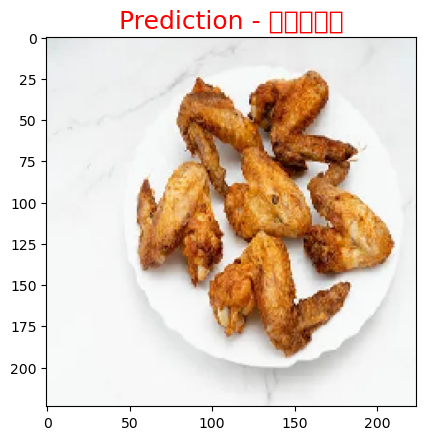

In [38]:
predict_image("./test/치킨날개.webp", model)

In [26]:
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(valid_data.labels,out)
print(f'Validation Accuracy: {val_acc:.2f}') 

Validation Accuracy: 0.81


In [27]:
import time
inp = np.random.randint(0,255,(1,224,224,3))
t1 = time.time()
out = model.predict(inp)
t2 = time.time()
print(f'Inference Time: {t2-t1}')
print(f'FPS: {1/(t2-t1)}')

1/1 [==============================] - 2s 2s/step
Inference Time: 1.5461130142211914
FPS: 0.6467832498672293
